In [1]:
#Add Dependencies
import pandas as pd
import numpy as np
import psycopg2 as pg
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import seaborn as sns

### Connection to the Postgres database and Retrive data from the tables

In [2]:
#Read Data from the PostgressSql
conn = pg.connect(user = "postgres",
                                  password = "akshaj10",
                                  host = "127.0.0.1",
                                  port = "5432",
                                  database = "movie_data")
sql1 = "SELECT * FROM oscar_metadata;"
combined_df = pd.read_sql_query(sql1, conn)
conn = None

In [3]:
#Load Data into Pandas Data frame and Display the dataframe.
combined_df.shape

(51147, 17)

In [4]:
# Filter all rows for US as the country
movie_us_df = combined_df[combined_df['country'] == 'United States of America'] 
movie_us_df.shape

(22647, 17)

In [5]:
# Find null values
for column in movie_us_df.columns:
    print(f"Column{column} has {movie_us_df[column].isnull().sum()} null values")

Columnimdb_id has 3 null values
Columnbudget has 0 null values
Columnoriginal_title has 0 null values
Columnpopularity has 0 null values
Columnrevenue has 0 null values
Columnruntime has 5 null values
Columntitle has 0 null values
Columnvote_average has 0 null values
Columnvote_count has 0 null values
Columnproduction has 0 null values
Columncountry has 0 null values
Columnnew_genre has 0 null values
ColumnRelease_year has 2 null values
Columnindex has 15911 null values
Columncategory has 15911 null values
Columnfilm has 15911 null values
Columnwinner has 15911 null values


In [6]:
#Set the index to IMDB_ID
movie_us_df = movie_us_df.set_index("imdb_id")
movie_us_df.head()

,budget,original_title,popularity,revenue,runtime,title,vote_average,vote_count,production,country,new_genre,Release_year,index,category,film,winner
imdb_id,,,,,,,,,,,,,,,,
tt0114709,30000000,Toy Story,30000000.0,373554033.0,81.0,Toy Story,7.7,5415.0,Pixar Animation Studios,United States of America,Animation,1995,7548.0,WRITING (Screenplay Written Directly for the S...,Toy Story,False
tt0114709,30000000,Toy Story,30000000.0,373554033.0,81.0,Toy Story,7.7,5415.0,Pixar Animation Studios,United States of America,Animation,1995,7514.0,MUSIC (Original Song),Toy Story,False
tt0114709,30000000,Toy Story,30000000.0,373554033.0,81.0,Toy Story,7.7,5415.0,Pixar Animation Studios,United States of America,Animation,1995,7508.0,MUSIC (Original Musical or Comedy Score),Toy Story,False
tt0113497,65000000,Jumanji,65000000.0,262797249.0,104.0,Jumanji,6.9,2413.0,TriStar Pictures,United States of America,Adventure,1995,NaN,None,None,None
tt0113228,0,Grumpier Old Men,0.0,0.0,101.0,Grumpier Old Men,6.5,92.0,Warner Bros.,United States of America,Romance,1995,NaN,None,None,None


In [7]:
columns =['budget','original_title','popularity','revenue','runtime','vote_average','vote_count','production','country','new_genre','Release_year', 'winner']

target = ['winner']

In [8]:
movie_us_df = movie_us_df.loc[:, columns].copy()
movie_us_df.shape

(22647, 12)

In [9]:
#Convert winner column into numbers 
movie_us_df["winner"] = movie_us_df["winner"].replace({True: 1, False: 0})
movie_us_df.shape

(22647, 12)

In [10]:
#Fill null values in winner column to zero 
movie_us_df["winner"] = movie_us_df["winner"].fillna(value=0)
movie_us_df.shape

(22647, 12)

In [11]:
# convert the 'Date' column to datetime format 
movie_us_df['Release_year'] = movie_us_df['Release_year'].astype('datetime64[ns]')

In [12]:
# Extract year from date 
movie_us_df['Release_year'] = pd.DatetimeIndex(movie_us_df['Release_year']).year
movie_us_df.shape

(22647, 12)

In [13]:
# Check the production unique value counts to see if binning is required
year_counts= movie_us_df.Release_year.value_counts()
year_counts

2014.0    727
2015.0    708
2013.0    700
2016.0    643
2012.0    624
         ... 
1897.0      1
1883.0      1
1904.0      1
1878.0      1
1913.0      1
Name: Release_year, Length: 130, dtype: int64

In [14]:
# Filter all rows for movies from 1990
movie_us_df = movie_us_df[movie_us_df['Release_year'] >= 1990] 
movie_us_df.shape

(11828, 12)

In [15]:
# convert the 'Date' column to datetime format 
movie_us_df['Release_year'] = movie_us_df['Release_year'].astype('str')

In [16]:
# Drop the Release year after filtering the data.
movie_us_df = movie_us_df.drop('Release_year',1)

In [17]:
# Create a title Dataframe.
title_df=pd.DataFrame(data=movie_us_df['original_title'],index=movie_us_df.index,copy=True)
title_df.head()

,original_title
imdb_id,
tt0114709,Toy Story
tt0114709,Toy Story
tt0114709,Toy Story
tt0113497,Jumanji
tt0113228,Grumpier Old Men


In [18]:
# Remove the movie title from the dataframe
movie_us_df = movie_us_df.drop('original_title',1)
movie_us_df.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,production,country,new_genre,winner
imdb_id,,,,,,,,,,
tt0114709,30000000,30000000.0,373554033.0,81.0,7.7,5415.0,Pixar Animation Studios,United States of America,Animation,0.0
tt0114709,30000000,30000000.0,373554033.0,81.0,7.7,5415.0,Pixar Animation Studios,United States of America,Animation,0.0
tt0114709,30000000,30000000.0,373554033.0,81.0,7.7,5415.0,Pixar Animation Studios,United States of America,Animation,0.0
tt0113497,65000000,65000000.0,262797249.0,104.0,6.9,2413.0,TriStar Pictures,United States of America,Adventure,0.0
tt0113228,0,0.0,0.0,101.0,6.5,92.0,Warner Bros.,United States of America,Romance,0.0


In [19]:
# Drop null rows
movie_us_df = movie_us_df.dropna(axis = 0,how= 'any')
movie_us_df.shape

(11824, 10)

In [20]:
# Generate our categorical variable list for movie dataset
movie_cat = movie_us_df.dtypes[movie_us_df.dtypes == "object"].index.tolist()

# Check the number of unique values in each column
movie_us_df[movie_cat].nunique()

production    3323
country          1
new_genre       20
dtype: int64

### One Hot encoding production -Using top 10 values

In [21]:
# Check the production unique value counts to see if binning is required
production_counts= movie_us_df.production.value_counts()
production_counts

Other                          1764
Paramount Pictures              409
Universal Pictures              318
Columbia Pictures               283
Walt Disney Pictures            247
                               ... 
Voltage Films                     1
Deuce of Spades Productions       1
Primal Pictures                   1
LEGO                              1
2 Man Production                  1
Name: production, Length: 3323, dtype: int64

In [22]:
# Determine which values to replace for bucketing
replace_production = list(production_counts[production_counts < 80].index)

# Replace in DataFrame
for production in replace_production:
    movie_us_df.production = movie_us_df.production.replace(production,"Other")


# Check to make sure binning was successful
movie_us_df.production.value_counts()

Other                                     9542
Paramount Pictures                         409
Universal Pictures                         318
Columbia Pictures                          283
Walt Disney Pictures                       247
Twentieth Century Fox Film Corporation     216
New Line Cinema                            212
Miramax Films                              207
Warner Bros.                               109
TriStar Pictures                           108
DreamWorks SKG                              93
Fox Searchlight Pictures                    80
Name: production, dtype: int64

In [23]:
# let's examine how many columns we will obtain after one hot encoding these variables
encode_df=pd.get_dummies(movie_us_df[movie_cat], drop_first=True)
encode_df.shape

(11824, 30)

In [24]:
# Merge one-hot encoded features and drop the originals
oscar_us_df = movie_us_df.merge(encode_df,left_index=True, right_index=True)
oscar_us_df = oscar_us_df.drop(movie_cat,1)
oscar_us_df.head(2)

,budget,popularity,revenue,runtime,vote_average,vote_count,winner,production_DreamWorks SKG,production_Fox Searchlight Pictures,production_Miramax Films,...,new_genre_History,new_genre_Horror,new_genre_Music,new_genre_Mystery,new_genre_Romance,new_genre_Science Fiction,new_genre_TV Movie,new_genre_Thriller,new_genre_War,new_genre_Western
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0035423,0,0.0,0.0,118.0,6.0,430.0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
tt0081145,0,0.0,0.0,94.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Univariate Selection

In [25]:
# Define the features set.
X = oscar_us_df.copy()
X = X.drop('winner', axis=1)
X.shape

(19904, 36)

In [26]:
# Define the target set(output label)
y = oscar_us_df['winner']
y.head(2)

imdb_id
tt0035423    0.0
tt0081145    0.0
Name: winner, dtype: float64

In [27]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)

In [28]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [29]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

In [30]:
featureScores

,Specs,Score
0,budget,8.019502e+10
1,popularity,8.019502e+10
2,revenue,1.067153e+12
3,runtime,1.363355e+04
4,vote_average,2.667407e+02
5,vote_count,6.029692e+06
6,production_DreamWorks SKG,3.236450e+01
7,production_Fox Searchlight Pictures,4.066548e+00
8,production_Miramax Films,2.908939e+02
9,production_New Line Cinema,3.997573e+01


In [31]:
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                            Specs         Score
2                         revenue  1.067153e+12
0                          budget  8.019502e+10
1                      popularity  8.019502e+10
5                      vote_count  6.029692e+06
3                         runtime  1.363355e+04
11  production_Paramount Pictures  5.465176e+02
8        production_Miramax Films  2.908939e+02
4                    vote_average  2.667407e+02
10               production_Other  2.281054e+02
22                new_genre_Drama  1.349538e+02


### Feature Importance

In [32]:
model = ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [33]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

[8.00298620e-02 8.04429036e-02 1.25859084e-01 1.14689119e-01
 1.24554528e-01 1.86530300e-01 5.31450140e-03 2.49883345e-03
 3.07409476e-02 3.88168759e-03 3.79711916e-02 4.81671339e-02
 1.85773064e-03 7.38484818e-03 7.10561149e-03 4.56556613e-03
 2.84867440e-03 2.73117881e-02 1.06355257e-02 1.11797533e-02
 9.33241202e-03 4.55091164e-03 3.38859074e-02 1.29590878e-03
 6.26615639e-03 1.23019221e-06 1.60061152e-03 3.99089820e-03
 1.44828823e-03 2.12551023e-03 6.51176903e-03 1.91712431e-03
 2.50621722e-03 5.48034698e-03 5.62966327e-04 4.95415175e-03]


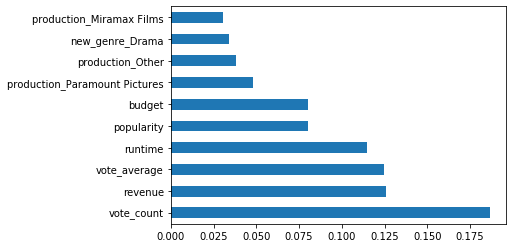

In [34]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

### Correlation Matrix with Heatmap

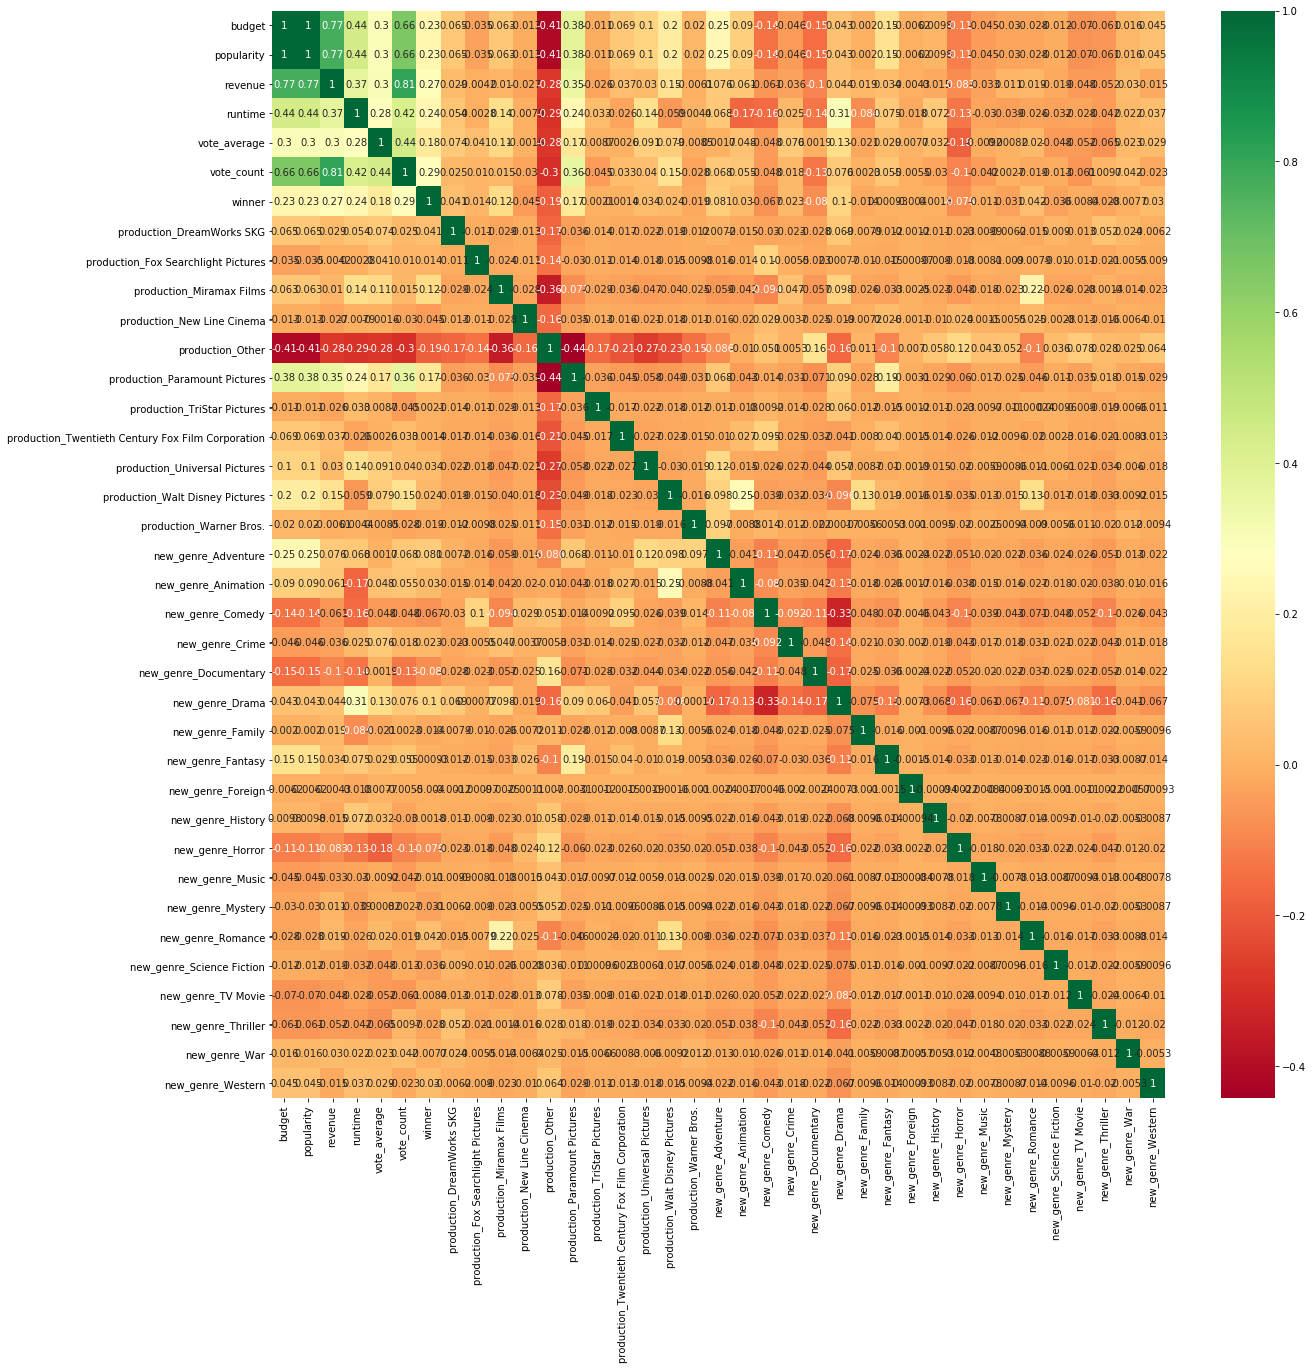

In [35]:
#get correlations of each features in dataset
corrmat = oscar_us_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(oscar_us_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [36]:
#Include only the top 10 best feature with relation to the target variable :
columns1 =['production_Miramax Films', 'new_genre_Drama', 'production_Other', 'production_Paramount Pictures','budget','popularity', 'runtime', 'vote_average', 'revenue', 'vote_count', 'winner']

target = ['winner']

In [37]:
oscar_us_df = oscar_us_df.loc[:, columns1].copy()
oscar_us_df.shape

(19904, 11)

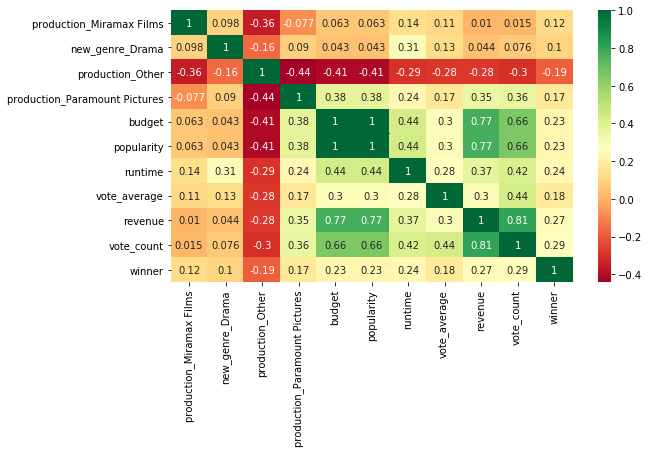

In [38]:
#get correlations of each features in dataset
corrmat = oscar_us_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(9,5))
#plot heat map
g=sns.heatmap(oscar_us_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")